# Hector V3.2.0 Tutorial

Hector is an open-source, object-oriented, Reduced Complexity Earth Systems Model (RCM). It models critical earth system processes on a global scale. As a computationally efficient model, Hector has many applications. It can be used to explore scenarios, generate large ensembles of results, explore key uncertainties, and emulate Earth System Models. There are three ways to use Hector: as a stand-alone executable, through the online HectorUI, and as an R package. Installation instructions and examples are available at https://github.com/jgcri/hector and https://github.com/jgcri/hectorui. 

Follow the appropriate [installation for your machine]( http://jgcri.github.io/hector/articles/BuildHector.html) to run locally. Here you will learn how to use the R hector package to run complete a Hector run, change a model parameter, and query results. 

## Getting started

In [1]:
# Load the Hector package (this requires that Hector has already been installed
# see http://jgcri.github.io/hector/articles/BuildHector.html)
library(hector)

# Package used to plot results
library(ggplot2)
theme_set(theme_bw(base_size = 20)) # plot setting
options(repr.plot.width=16, repr.plot.height=8)

The Hector R package ships with a handful of scenarios, located in the input diretory of the package. See a list of the ini (initialization) files using the `system.file` function. Each one of these files is a configuration file for a hector run, each file contains the default model parameters and the emission time-series for the SSP scenarios.

In [2]:
files <- list.files(system.file("input", package = "hector"))
cat(files, sep= "\n")

hector_ssp119.ini
hector_ssp126.ini
hector_ssp245.ini
hector_ssp370.ini
hector_ssp434.ini
hector_ssp460.ini
hector_ssp534-over.ini
hector_ssp585.ini
tables


## Run SSP2-4.5

Use the `newcore` function to set up a Hector core to run the SSP2-4.5 scenario.

In [3]:
# Select the ini file to use.
ini_file = system.file("input/hector_ssp245.ini", package = "hector")

# Set up a Hector core using the ini file. 
hcore = newcore(inifile = ini_file, name = "SSP2-45") 

# Run Hector! It will take less than a second.
run(core = hcore)

Hector core:	SSP2-45
Start date:	1745
End date:	2300
Current date:	2300
Input file:	C:\Users\brow521\AppData\Local\R\win-library\4.4\hector\input\hector_ssp245.ini

Use the `fetchvars` function to query the Hector results. It can be used to get a time series of results or model parameters.

In [4]:
# A vector of the variables we are interested in. Hector has a number of helper functions that return the 
# string names recognized by the Hector core. 
vars = c(GLOBAL_TAS(), CONCENTRATIONS_CO2())
cat(vars, sep = "\n")

global_tas
CO2_concentration


In [5]:
out_ssp245 = fetchvars(core = hcore,         # the active hector core
                       dates = 1850:2100,    # the vector contains the years of interest 
                       vars = vars)          # the vector contains the variables of interest

head(out_ssp245)

,scenario,year,variable,value,units
,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,SSP2-45,1850,global_tas,-0.10249176,degC
2,SSP2-45,1851,global_tas,-0.09068423,degC
3,SSP2-45,1852,global_tas,-0.08036054,degC
4,SSP2-45,1853,global_tas,-0.08557470,degC
5,SSP2-45,1854,global_tas,-0.09308445,degC
6,SSP2-45,1855,global_tas,-0.08554412,degC


In [6]:
# After fetching the restults from Hector shut down the Hector core, this is a good practice. 
shutdown(hcore)

Hector core (INACTIVE)

Now we can plot the Hector results.

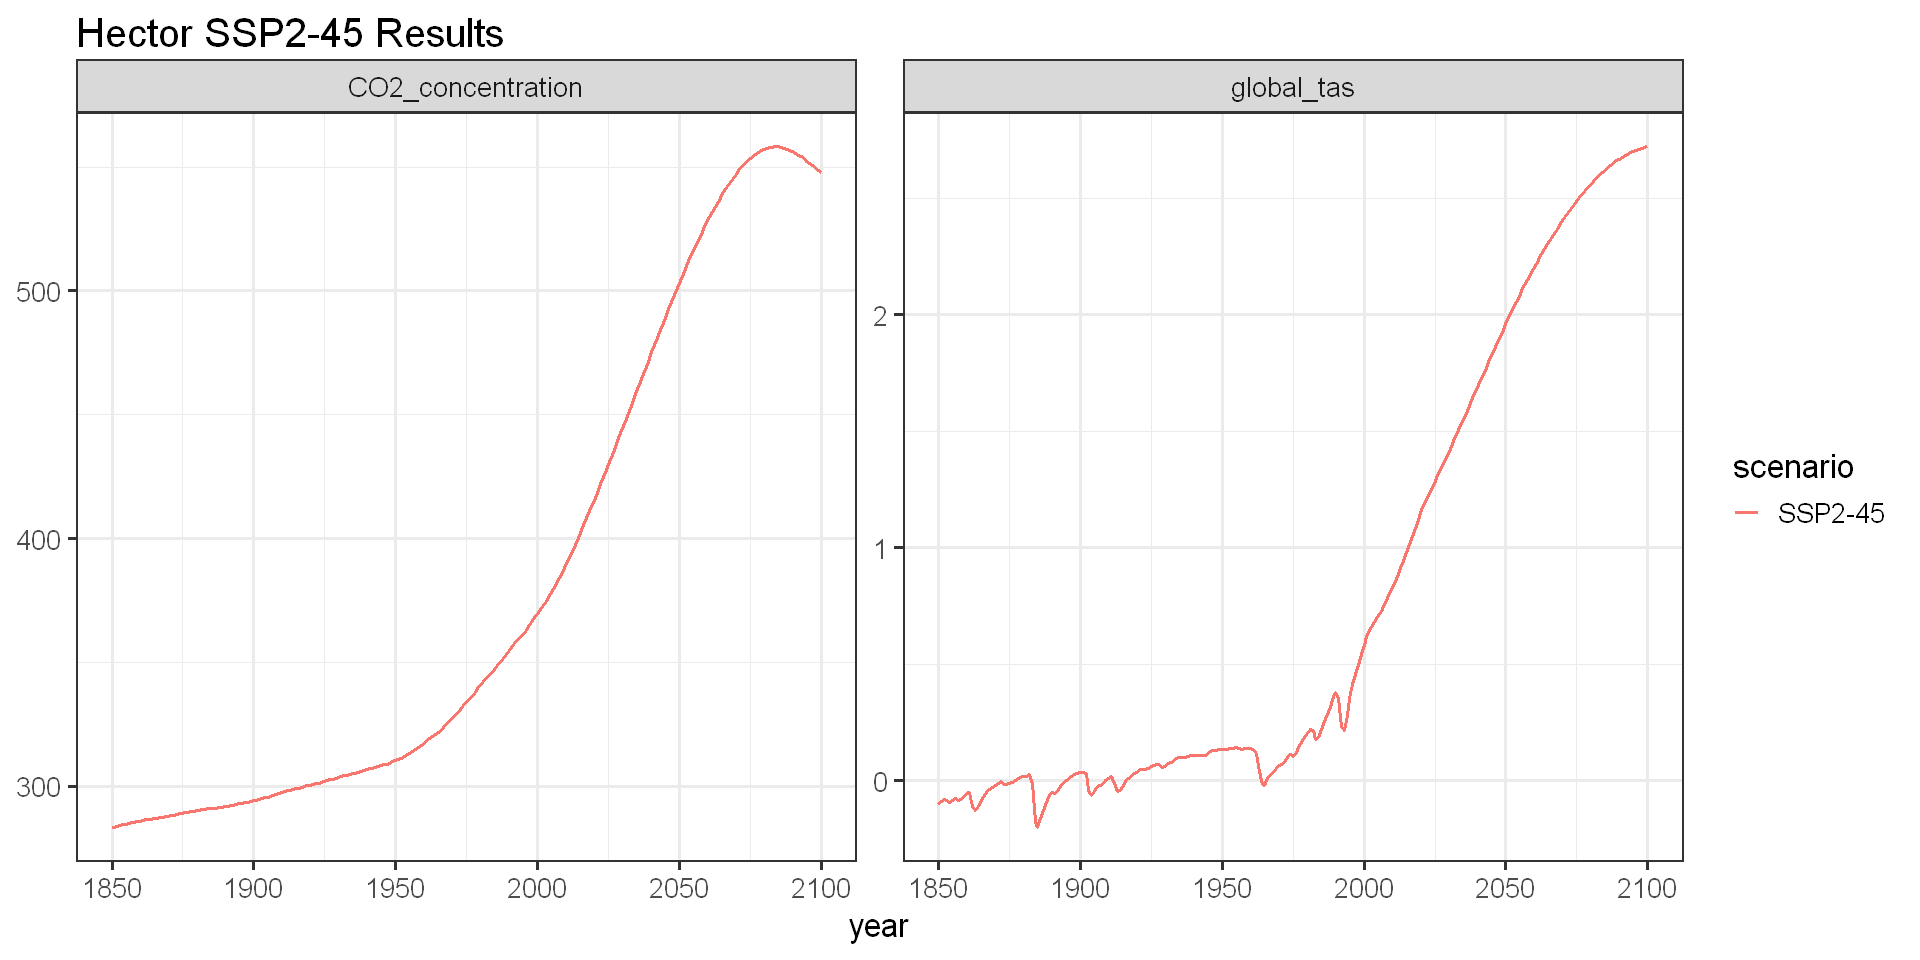

In [8]:
ggplot(data = out_ssp245) + 
    geom_line(aes(year, value, color = scenario), linewidth = 1) + 
    labs(title = "Hector SSP2-45 Results") + 
    facet_wrap("variable", scales = "free") +
    labs(y = NULL)


## How to change a Hector parameter

In this example we will learn how to change Hector's equilibrium climate sensitivity parameter (`ECS`). 

In [9]:
# First set up a Hector core
ini_file = system.file("input/hector_ssp245.ini", package = "hector")
hcore = newcore(inifile = ini_file, name = "SSP2-45 higher ECS") 
run(core = hcore)

Hector core:	SSP2-45 higher ECS
Start date:	1745
End date:	2300
Current date:	2300
Input file:	C:\Users\brow521\AppData\Local\R\win-library\4.4\hector\input\hector_ssp245.ini

Use the `fetchvar` to extract the default ECS value. 

In [10]:
default_ECS = fetchvars(core = hcore, dates = NA, vars = ECS())
default_ECS

scenario,year,variable,value,units
<chr>,<dbl>,<chr>,<dbl>,<chr>
SSP2-45 higher ECS,NA,S,3,degC


Here, we will double the default ECS and pass the information to the Hector core by calling `setvar()`. The `setvar()` function needs the string name for units, which we can get from the helper `getunits()` function.

In [11]:
# double the default ECS value
double_ECS = 2 * default_ECS$value
double_ECS

[1] 6

In [12]:
ECS_units = getunits(vars = ECS())
ECS_units

[1] "degC"

In [13]:
setvar(core = hcore, 
       dates = NA, 
       var = ECS(), 
       values = double_ECS, 
       unit = ECS_units)

In [14]:
run(core = hcore)

Auto-resetting core to 0



Hector core:	SSP2-45 higher ECS
Start date:	1745
End date:	2300
Current date:	2300
Input file:	C:\Users\brow521\AppData\Local\R\win-library\4.4\hector\input\hector_ssp245.ini

In [15]:
out_ssp245_newECS = fetchvars(core = hcore, dates = 1850:2100, vars = vars)

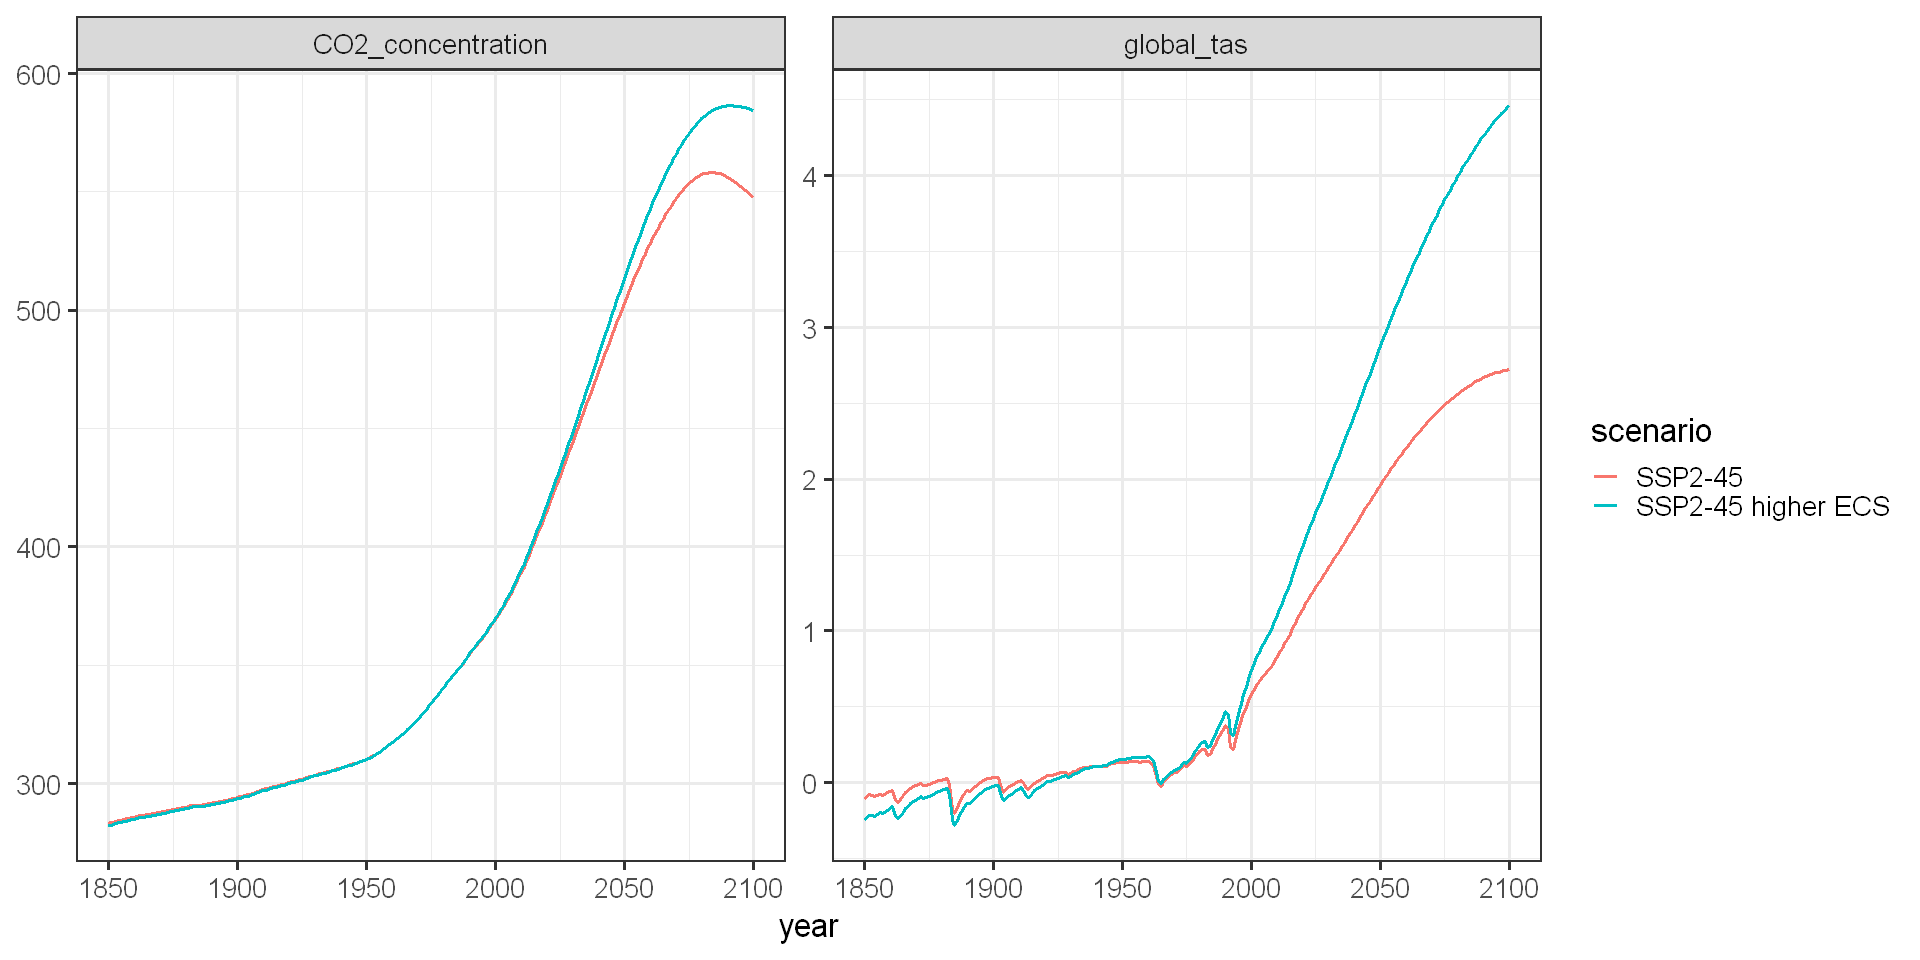

In [16]:
# Combine the data frames into a single data frame, then plot it. 
results <- rbind(out_ssp245, out_ssp245_newECS)

ggplot(data = results) + 
    geom_line(aes(year, value, color = scenario), linewidth = 1) + 
    facet_wrap("variable", scales = "free") +
    labs(y = NULL)

## Modifying an  emissions pathway

RCMS such as Hector can be used to explore custom/new emissions scenarios. Using the `setvars` function users can modify the emission input pathways, allowing users to test out new scenarios. Here, we will modify the CO$_{2}$ emissions from fossil fuel and industry (`ffi_emissions`) to demonstrate how to change emission pathways. **Note** that a total of 40 different emission pathways can be set using this approach, `ffi_emissions` is just the example we are using here.

In [17]:
# Run to see documentation on Hector emissions
help(emissions)

EMISSIONS_BC {hector},R Documentation


In [18]:
# Again start off with an active Hector core and complete a default run so that we have some data to compare with.

ini_file = system.file("input/hector_ssp245.ini", package = "hector")
hcore = newcore(inifile = ini_file, name = "SSP2-45") 
run(core = hcore)

Hector core:	SSP2-45
Start date:	1745
End date:	2300
Current date:	2300
Input file:	C:\Users\brow521\AppData\Local\R\win-library\4.4\hector\input\hector_ssp245.ini

In [19]:
# Fetch a copy of the global temperature and FFI emissions to compare with new run. 
original_results <- fetchvars(core = hcore, 
                            dates = 1850:2100,                          # date(s) interested in 
                            vars = c(FFI_EMISSIONS(), GLOBAL_TAS()))     # variable(s) intrested in 
original_results$scenario <- "Original SSP2-45"

In [20]:
# Save a copy the FFI emissions pathway, this is the dataframe we will be manipulating. 
ffi_emissions <- fetchvars(core = hcore, 
                            dates = 1850:2100,          # date(s) interested in 
                            vars = FFI_EMISSIONS())     # variable(s) intrested in 

head(ffi_emissions)

,scenario,year,variable,value,units
,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,SSP2-45,1850,ffi_emissions,0.05138490,Pg C/yr
2,SSP2-45,1851,ffi_emissions,0.05156231,Pg C/yr
3,SSP2-45,1852,ffi_emissions,0.05364238,Pg C/yr
4,SSP2-45,1853,ffi_emissions,0.05595235,Pg C/yr
5,SSP2-45,1854,ffi_emissions,0.06589565,Pg C/yr
6,SSP2-45,1855,ffi_emissions,0.06656059,Pg C/yr


Now, for the sake of this example let's cut the emissions in half. 

In [21]:
ffi_emissions$value <- ffi_emissions$value * 0.5

In [22]:
head(ffi_emissions)

,scenario,year,variable,value,units
,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,SSP2-45,1850,ffi_emissions,0.02569245,Pg C/yr
2,SSP2-45,1851,ffi_emissions,0.02578115,Pg C/yr
3,SSP2-45,1852,ffi_emissions,0.02682119,Pg C/yr
4,SSP2-45,1853,ffi_emissions,0.02797617,Pg C/yr
5,SSP2-45,1854,ffi_emissions,0.03294783,Pg C/yr
6,SSP2-45,1855,ffi_emissions,0.03328030,Pg C/yr


In [23]:
# Use setvars to pass in the new emissions pathway. 
setvar(core = hcore, 
       dates = ffi_emissions$year, 
       var = ffi_emissions$variable, 
       values = ffi_emissions$value, 
       unit = ffi_emissions$units)
run(hcore)

Auto-resetting core to 1849



Hector core:	SSP2-45
Start date:	1745
End date:	2300
Current date:	2300
Input file:	C:\Users\brow521\AppData\Local\R\win-library\4.4\hector\input\hector_ssp245.ini

In [24]:
# Query results 
reduced_ffi_results <- fetchvars(core = hcore, 
                            dates = 1850:2100,                          # date(s) interested in 
                            vars = c(FFI_EMISSIONS(), GLOBAL_TAS()))     # variable(s) intrested in 
reduced_ffi_results$scenario <- "reduced ffi SSP2-45"

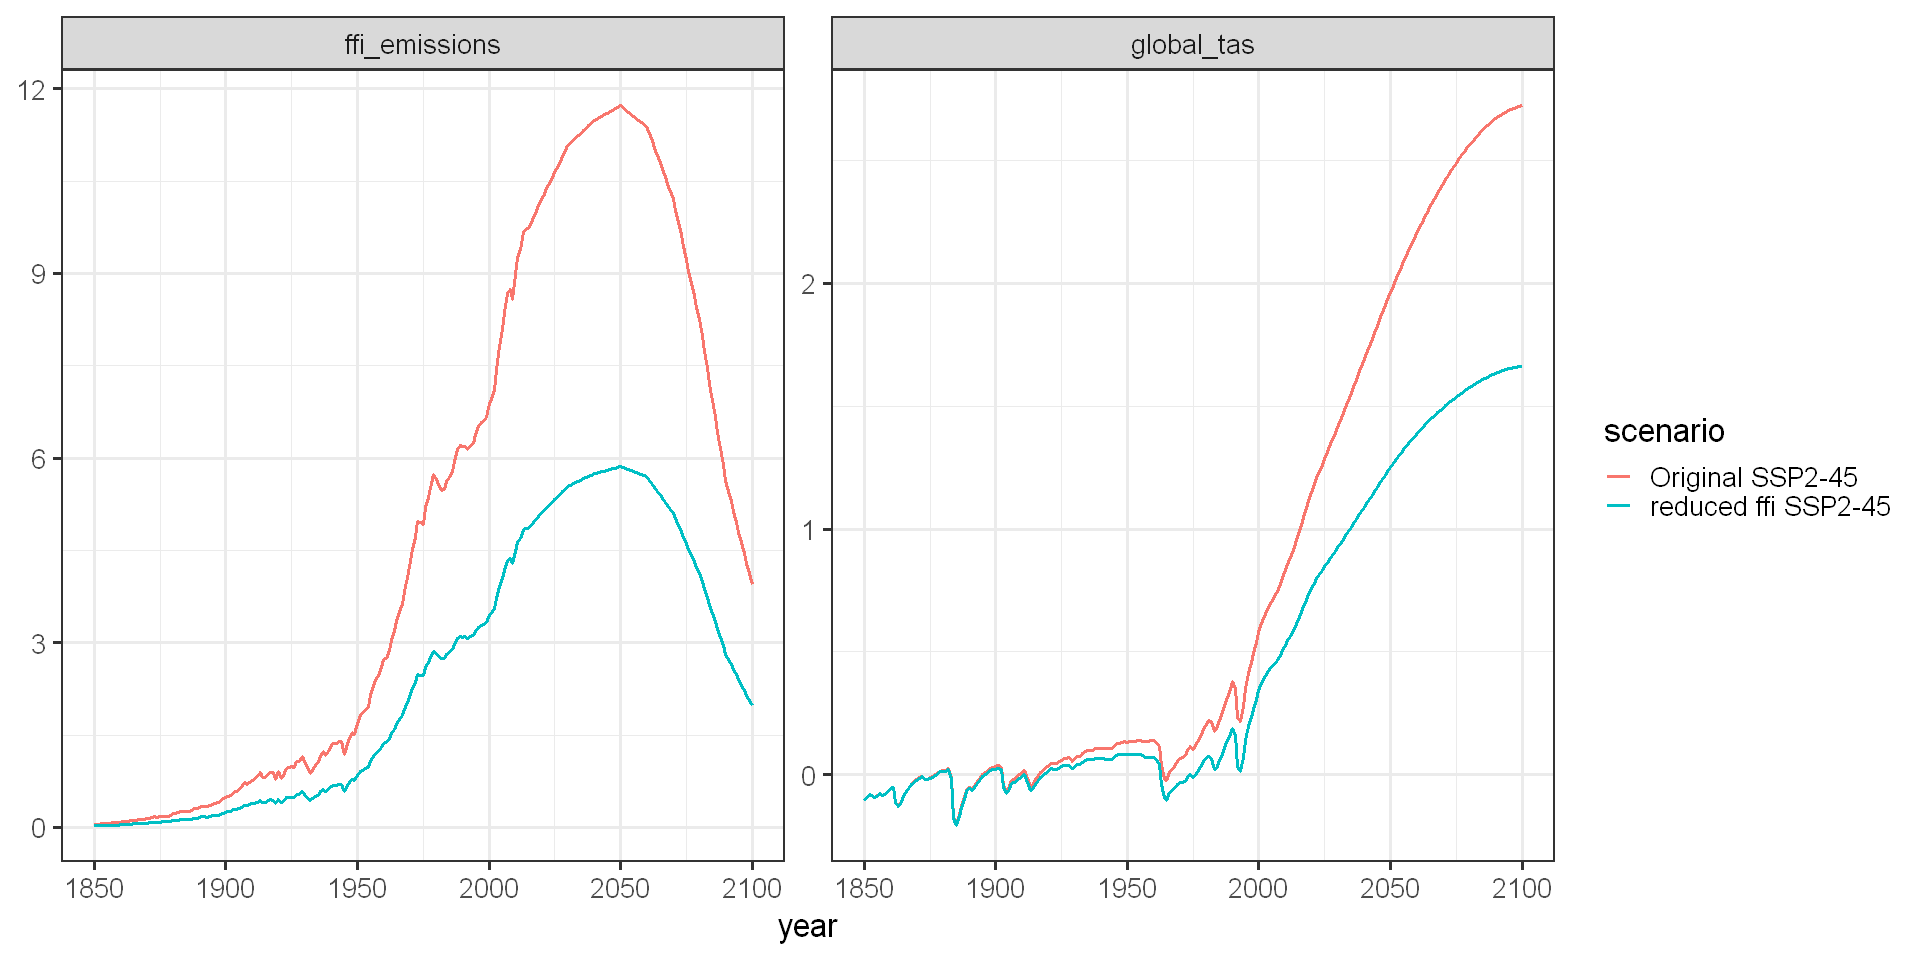

In [25]:
# Combine the data frames into a single data frame, then plot it. 
results <- rbind(original_results, reduced_ffi_results)

ggplot(data = results) + 
    geom_line(aes(year, value, color = scenario), linewidth = 1) + 
    facet_wrap("variable", scales = "free") +
    labs(y = NULL) 

Check out more examples at http://jgcri.github.io/hector/.